# 고객 세그먼테이션

고객 세그먼테이션은 다양한 기준으로 고객을 분류하는 기법을 지칭 <br>
-> 주요 목표는 타깃 마케팅
타깃 마케팅 ; 고객을 여러 특성에 맞게 세분홯서 그 유형에 따라 맞춤형 마케팅이나 서비스를 제공하는 것<br>

고객 세크먼테이션은 고객의 어떤 요소를 기반으로 군집화할 것인가를 결정하는 것이 중요<br>
여기서는 기본적인 고객 분석 요소인 RFM 기법을 이용 <br>
RFM 기법은 Recency(R), Frequency(F), Monetary Value(M)의 각 앞 글자를 합한 것으로서 각 단어의 의미는 다음과 같음<br>

- Recency(R) : 가장 최근 상품 구입일에서 오늘까지의 기간<br>
- Frequency (F) : 상품 구매 횟수<br>
- Monetary Value (M) : 총 구매 금액<br>

### 데이터 클렌징

In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df =pd.read_excel(io="/Users/ijiseon/Desktop/Online Retail.xlsx")

In [2]:
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [3]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


> Null 데이터 제거 : 특히 CustomerID 가 Null인 데이터가 많음. 고객 세그먼테이션을 수행하므로 고객 식별 번호가 없는 데이터는 필요가 없기에 삭제


> 오류 데이터 삭제: 대표적인 오류 데이터는 Quantity 또는 UnitPrice가 0보다 작은 경우. 사실 Quantity가 0보다 작은 경우는 오류 데이터라기보다는 반환을 뜻하는 값. 이 경우 invoiceNo의 앞자리는 C로 돼 있음. 분석의 효율성을 위해 이 데이터는 모두 삭제

In [4]:
retail_df = retail_df[retail_df["Quantity"]>0]
retail_df = retail_df[retail_df["UnitPrice"]>0]
retail_df = retail_df[retail_df["CustomerID"].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

> Null 값은 칼럼에 존재하지 않음. 

In [5]:
retail_df["Country"].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [6]:
retail_df = retail_df[retail_df["Country"]=="United Kingdom"]
print(retail_df.shape)

(354321, 8)


> 영국이 대다수를 차지하므로 다른 국가의 데이터는 모두 제외

### RFM 기반 데이터 가공

In [7]:
retail_df["sale_amount"] = retail_df["Quantity"]*retail_df["UnitPrice"]
retail_df["CustomerID"]= retail_df["CustomerID"].astype(int)

In [8]:
print(retail_df["CustomerID"].value_counts().head(5))
print(retail_df.groupby("CustomerID")["sale_amount"].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [9]:
retail_df.groupby(["InvoiceNo","StockCode"])["InvoiceNo"].count().mean()

1.028702077315023

In [11]:
# DataFrame의 groupby()의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceData 칼럼의 max()에서 데이터 가공
# Frequency는 InvoiceNo 칼럼의 count(), Monetary value는 sale_amount 칼럼의 sum()

aggregations = {
    "InvoiceDate":"max",
    "InvoiceNo":"count",
    "sale_amount":"sum"
}

cust_df = retail_df.groupby("CustomerID").agg(aggregations)

# groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경

cust_df = cust_df.rename(columns = {"InvoiceDate":"Recency",
                                   "InvoiceNo":"Frequency",
                                   "sale_amount":"Monetary"
                                   }
                        )

cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


In [12]:
import datetime as dt

cust_df["Recency"] = dt.datetime(2011,12,10) - cust_df["Recency"]
cust_df["Recency"] = cust_df["Recency"].apply(lambda x : x.days+1)

print("cust_df 로우와 칼럼 건수는 ", cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


> 온라인 판매 데이터 세트는 소매 업체의 대규모 주문을 포함하고 있음. 이들은 주문 횟수와 주문 금액에서 개인 고객 주문과 매우 큰 차이를 나타내고 있으며 이로 인해 매우 왜곡된 데이터 분포도를 가지게 되어 군집화가 한쪽 군집에만 집중되는 현상이 발생. 

> **왜곡된 데이터 분포도에서 군집화를 수행할 때 어떤 현상이 발생하는지** <br>
왜곡 정도가 매우 높은 데이터 세트에 K-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행됨. 

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

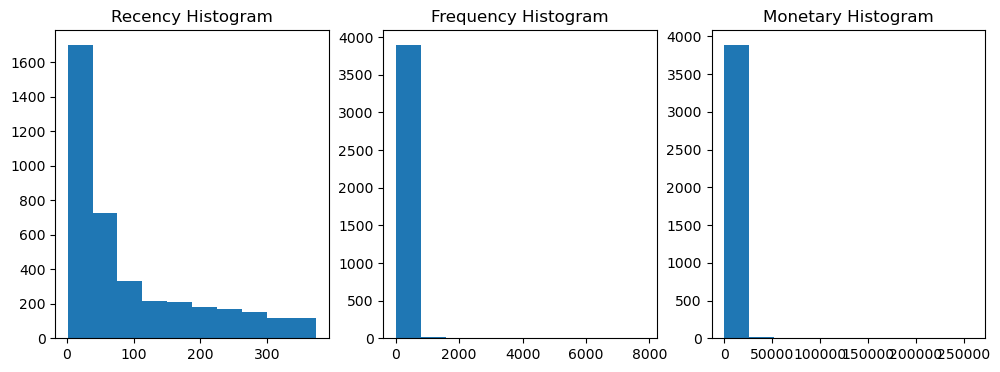

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)

ax1.set_title("Recency Histogram")
ax1.hist(cust_df["Recency"])

ax2.set_title("Frequency Histogram")
ax2.hist(cust_df["Frequency"])

ax3.set_title("Monetary Histogram")
ax3.hist(cust_df["Monetary"])

In [14]:
cust_df[["Recency","Frequency","Monetary"]].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[["Recency","Frequency","Monetary"]].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df["cluster_label"] = labels

print("실루엣 스코어는 : {0:.3f}".format(silhouette_score(X_features_scaled, labels)))

/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


실루엣 스코어는 : 0.592


In [16]:
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init

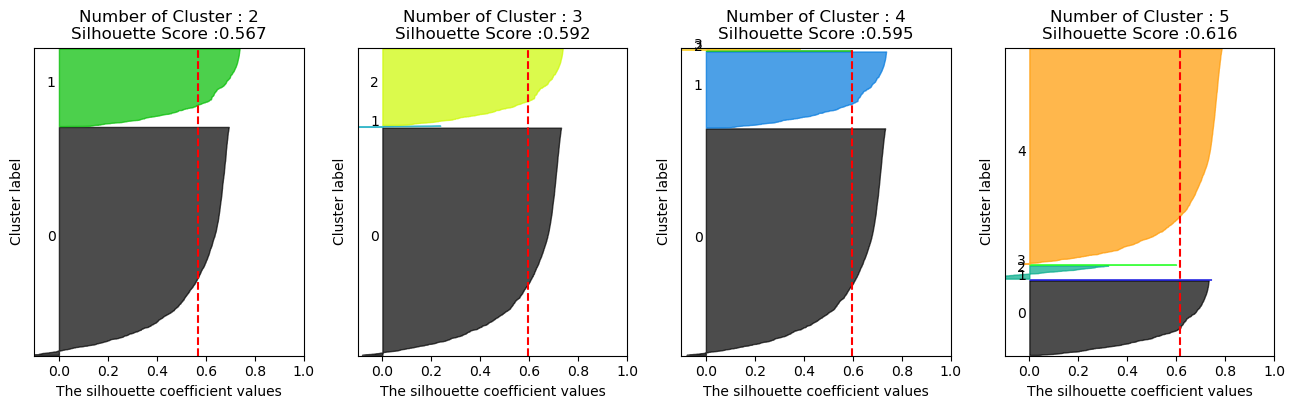

In [18]:
visualize_silhouette([2,3,4,5],X_features_scaled)

In [19]:
#군집 개수별로 군집화 구성을 시각화 하는 함수
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()


/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/f4/skyf3wfx5570p30yjkrfkxd00000gn/T/ipykernel_47539/4046894625.py:36: UserWarning: You passed a edgecolor/edgecolors ('k

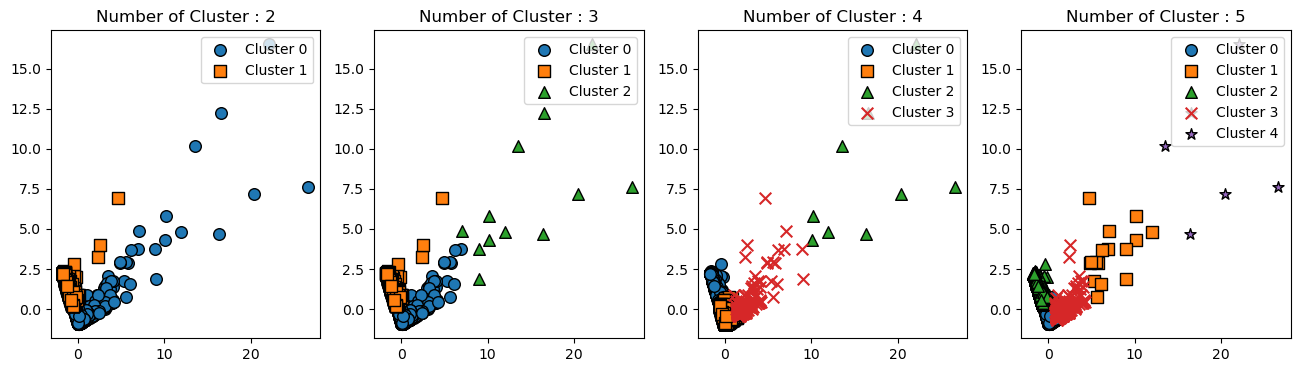

In [20]:
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

> 군집이 2개일 경우 0번 군집과 1번 군집이 너무 개괄적으로 군집화됐음. 군집 수를 증가시키며 개선이 가능할 것으로 예상됐는데, 실제 결과는 너무나 달랐음. 군집이 3개 이상일 때부터는 데이터 세트의 개수가 너무 작은 군집이 만들어짐. 이 군집에 속한 데이터는 개수가 작을뿐더러 실루엣 계수 역시 상대적으로 매우 작음. 또한 군집 내부에서도 데이터가 광범위하게 퍼져 있음. <br>

> 소수의 데이터 세트는 바로 앞에서 왜곡된 데이터 값인 특정 소매점의 대량 주문 구매 데이터. 이 데이터 세트의 경우 데이터 값이 거리 기반으로 광범위하게 퍼져 있어서 군집 수를 계속 늘려봐야 이 군집만 지속적으로 분리하게 되기에 의미 없는 군집화 결과로 이어짐 <br>

> 물론 이러한 특이한 데이터 세트를 분리하고 도출하는 것이 군집화의 목표이기도 함. 하지만 이정도로 크게 왜곡된 데이터 세트의 도출은 굳이 군집화를 이용하지 않고도 간단한 데이터 분석만으로도 충분히 가능. 

=> 지나치게 왜곡된 데이터 세트는 K-평균과 같은 거리 기반 군집화 알고리즘에서 지나치게 일반적인 군집화 결과를 도출하게 됨

데이터 세트의 왜곡 정도를 낮추기 위해 가장 자주 사용되는 방법은 데이터 값에 로그(log)를 적용하는 로그 변환. <br>
온라인 판매 데이터 세트의 왜곡 정도를 낮추기 위해서 전체 데이터를 로그 변환한 뒤에 K-평균 알고리즘을 적용

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

In [23]:
# Recency, Frequency, Monetary 칼럼에 np.log1p()로 Log Transformation
cust_df["Recency_log"] = np.log1p(cust_df["Recency"])
cust_df["Frequency_log"] = np.log1p(cust_df["Frequency"])
cust_df["Monetary_log"] = np.log1p(cust_df["Monetary"])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[[ "Recency_log", "Frequency_log", "Monetary_log" ]].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df["cluster_labels"]=labels

print("실루엣 스코어는 : {0:.3f}".format(silhouette_score(X_features_scaled, labels)))

/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


실루엣 스코어는 : 0.303


> 실루엣 스코어는 로그 변환하기 전보다 떨어짐. 하지만 실루엣 스코어의 절대치가 중요한 것이 아님. 어떻게 개별 군집이 더 균일하게 나뉠 수 있는지가 더 중요. 

/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init

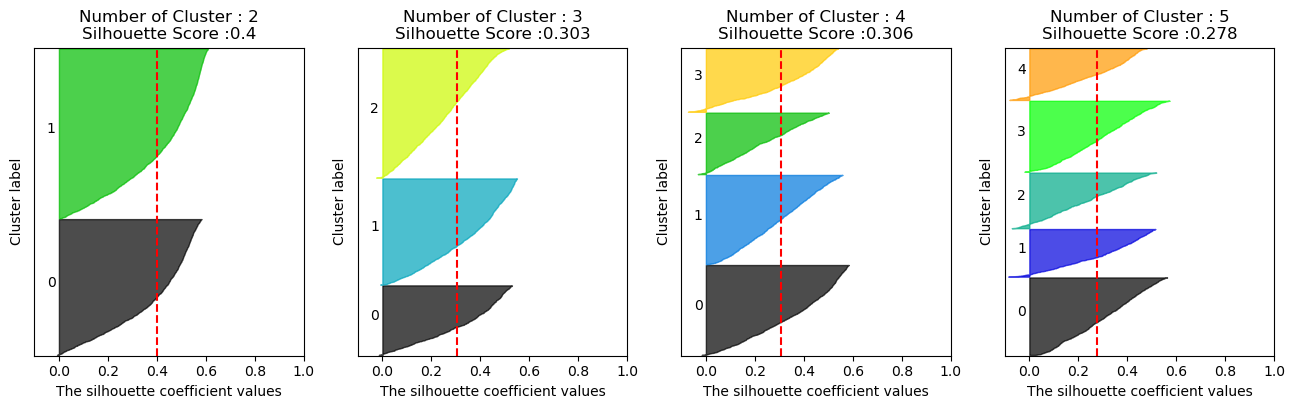

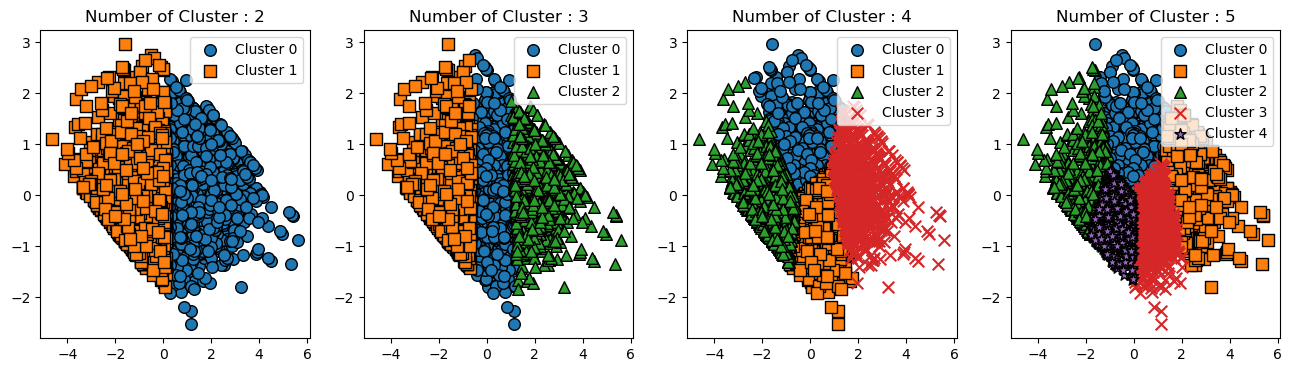

In [24]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)